# Assignment 1: Algorithm Selection -- Practical Machine Learning

A running set of experiments and data analysis completed in accordance with the assignment description. I chose to use the [`Wine Quality` dataset](https://archive-beta.ics.uci.edu/dataset/186/wine+quality).

Imports for this project will be introduced as they are needed for clarity and usability.

For much of the data analysis, I model my process after Chapter 2 of "[Hands On Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)" By Aurelien Geron, my go to reference for basic ML operations.

In [37]:
import sys
from pathlib import Path

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [38]:
import pandas as pd
red_wine_data = pd.read_csv("data/winequality-red.csv", sep=';') # Examining the raw `.txt` file, separate on the ';' char
red_wine_data.head() # View the first five elements to ensure the data was loaded correctly

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [39]:
red_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [40]:
red_wine_data["fixed acidity"].value_counts()

7.2     67
7.1     57
7.8     53
7.5     52
7.0     50
        ..
13.5     1
13.8     1
13.4     1
4.7      1
5.5      1
Name: fixed acidity, Length: 96, dtype: int64

In [41]:
red_wine_data["density"].quantile(0.97)


1.000306

In [42]:
red_corr_matrix = red_wine_data.corr()
red_corr_matrix["alcohol"].sort_values(ascending=False)

alcohol                 1.000000
quality                 0.476166
pH                      0.205633
citric acid             0.109903
sulphates               0.093595
residual sugar          0.042075
fixed acidity          -0.061668
free sulfur dioxide    -0.069408
volatile acidity       -0.202288
total sulfur dioxide   -0.205654
chlorides              -0.221141
density                -0.496180
Name: alcohol, dtype: float64

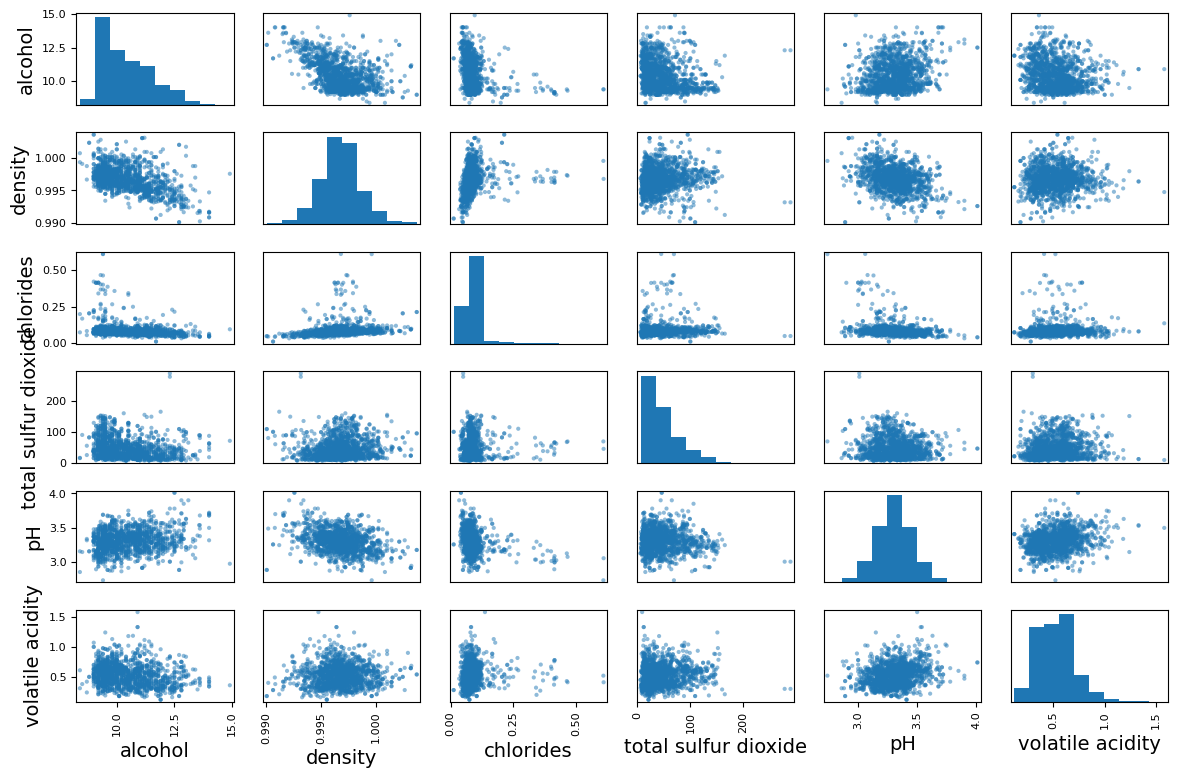

In [54]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

attributes = ["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]
scatter_matrix(red_wine_data[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plots")

#### Visualization

To better understand the data given, I chose to examine things visually. I also pulled in the convenient figure saving function provided by [this notebook.](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb)

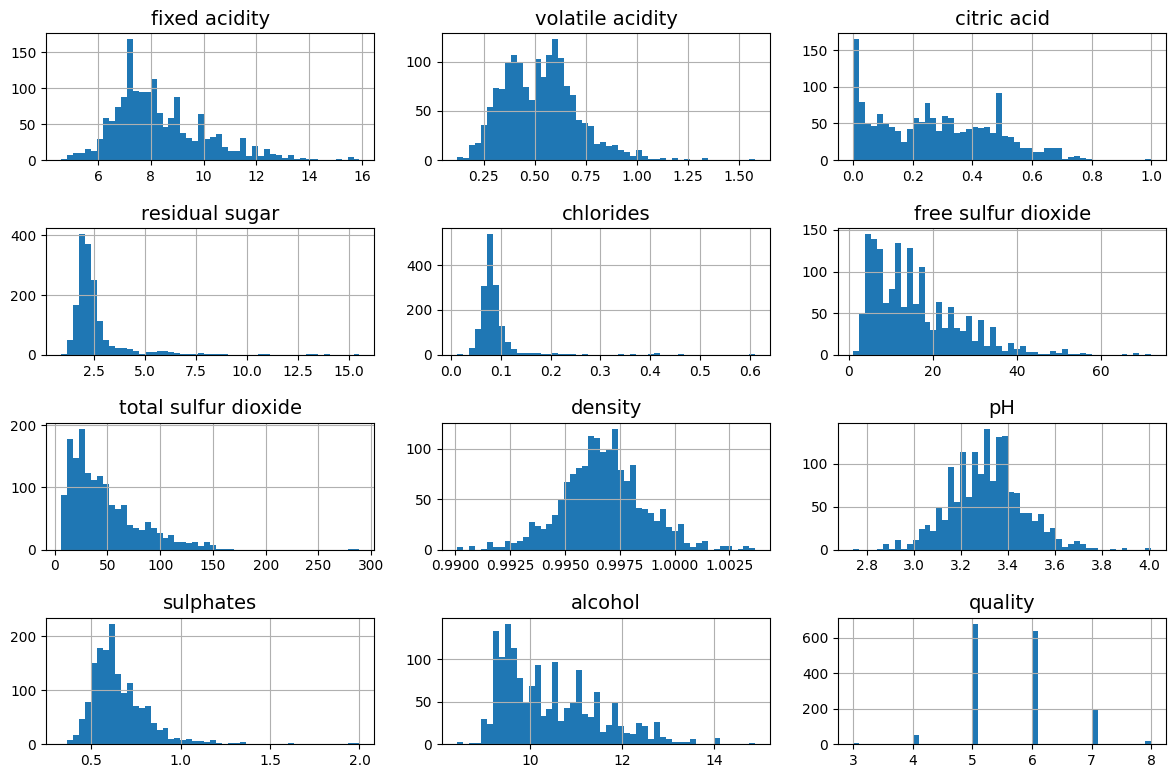

In [44]:
import matplotlib.pyplot as plt
import sys

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

red_wine_data.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [45]:
red_wine_data_copy = red_wine_data

red_wine_no_outliers = red_wine_data_copy[(red_wine_data_copy["quality"] > 4) &  (red_wine_data_copy["quality"] < 8)]
red_wine_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1518 non-null   float64
 1   volatile acidity      1518 non-null   float64
 2   citric acid           1518 non-null   float64
 3   residual sugar        1518 non-null   float64
 4   chlorides             1518 non-null   float64
 5   free sulfur dioxide   1518 non-null   float64
 6   total sulfur dioxide  1518 non-null   float64
 7   density               1518 non-null   float64
 8   pH                    1518 non-null   float64
 9   sulphates             1518 non-null   float64
 10  alcohol               1518 non-null   float64
 11  quality               1518 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 154.2 KB


In [ ]:
red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np


red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()

p_grid = {"max_depth": [2], "random_state": [0]}

rfc = RandomForestClassifier(max_depth=2, random_state=0)

num_folds = 10

non_nested_scores = np.zeros(num_folds)

for i in range(num_folds):
    inner_cv = KFold(n_splits=num_folds, shuffle=True, random_state=0)

    clf = GridSearchCV(estimator=rfc, param_grid=p_grid, cv=inner_cv)
    clf.fit(red_feat, np.ravel(red_qual))
    non_nested_scores[i] = clf.best_score_

print(
    "Average difference of {:6f} with max accuracy of {:6f}.".format(
        non_nested_scores.mean(), non_nested_scores.max()
    )
)

Average difference of 0.610047 with max accuracy of 0.610047.


In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np

red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")
 
print('Cross Validation accuracy scores for Random Forest: %s' % scores)
 
print('Cross Validation accuracy for Random Forest: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores for Random Forest: [0.56578947 0.61842105 0.61842105 0.53947368 0.55263158 0.69078947
 0.64473684 0.59210526 0.64238411 0.60264901]
Cross Validation accuracy for Random Forest: 0.607 +/- 0.044


In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import SVC
import numpy as np

red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), SVC())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")
 
print('Cross Validation accuracy scores for Support Vector Machine: %s' % scores)
 
print('Cross Validation accuracy for Support Vector Machine: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores for Support Vector Machine: [0.52631579 0.65131579 0.58552632 0.49342105 0.53289474 0.71710526
 0.625      0.59210526 0.63576159 0.58940397]
Cross Validation accuracy for Support Vector Machine: 0.595 +/- 0.063


In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

red_feat = red_wine_no_outliers[["alcohol", "pH", "density", "chlorides", "citric acid", "total sulfur dioxide", "free sulfur dioxide"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), LogisticRegression())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")
 
print('Cross Validation accuracy scores for Logistic Regression: %s' % scores)
 
print('Cross Validation accuracy for Logistic Regression: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores for Logistic Regression: [0.50657895 0.55921053 0.65131579 0.45394737 0.59868421 0.71052632
 0.61184211 0.57236842 0.66225166 0.56953642]
Cross Validation accuracy for Logistic Regression: 0.590 +/- 0.072


In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import numpy as np

red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")
 
print('Cross Validation accuracy scores for Decision Tree Classifier: %s' % scores)
 
print('Cross Validation accuracy for Decision Tree Classifier: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores for Decision Tree Classifier: [0.52631579 0.51315789 0.52631579 0.48684211 0.50657895 0.55921053
 0.5        0.44736842 0.46357616 0.54966887]
Cross Validation accuracy for Decision Tree Classifier: 0.508 +/- 0.033


In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import numpy as np

red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), tree.DecisionTreeRegressor())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")
 
print('Cross Validation accuracy scores for Decision Tree Regressor: %s' % scores)
 
print('Cross Validation accuracy for Decision Tree Regressor: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores for Decision Tree Regressor: [0.61842105 0.51315789 0.38815789 0.49342105 0.51973684 0.49342105
 0.47368421 0.46052632 0.51655629 0.49006623]
Cross Validation accuracy for Decision Tree Regressor: 0.497 +/- 0.054


In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier())
#
# Pass instance of pipeline and training and test data set
# cv=10 represents the StratifiedKFold with 10 folds
#
scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")
 
print('Cross Validation accuracy scores for Gradient Boosting Classifier: %s' % scores)
 
print('Cross Validation accuracy for Gradient Boosting Classifier: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores for Gradient Boosting Classifier: [0.58552632 0.59210526 0.60526316 0.51315789 0.57236842 0.65789474
 0.59210526 0.56578947 0.60264901 0.56953642]
Cross Validation accuracy for Gradient Boosting Classifier: 0.586 +/- 0.035


In [53]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

X, y = make_friedman1(n_samples = 50, n_features=10, random_state=0)
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selector.support_

array([ True,  True,  True,  True,  True, False, False, False, False,
       False])